## Importing libraries

In [1]:
import pandas as pd
import numpy as np

import time
from tqdm import tqdm_notebook

In [2]:
import gcsfs

In [3]:
import glob

In [4]:
import pyarrow

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams

In [8]:
import seaborn as sns

In [6]:
from dask.distributed import Client, progress, LocalCluster
import dask

In [7]:
import dask.dataframe as dd

In [9]:
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace import sarimax

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,  plot_pacf

In [10]:
import warnings
warnings.filterwarnings('ignore')
import itertools

## Importing data

In [11]:
cluster = LocalCluster(processes=True, n_workers=4)
client = Client(cluster)

In [13]:
dask.__version__

'2.8.0'

In [14]:
gcs = gcsfs.GCSFileSystem()

In [15]:
filelist = gcs.glob('nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/*.parquet/')
filelist_gcs = ['gcs://' + x for x in filelist]
filelist_gcs

['gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-01.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-02.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-03.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-04.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-05.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-06.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-07.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-08.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-09.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-10.parquet',
 'gcs://nyc-taxi-data-2018-2019/yellow_tripdata_2018_hr/yellow_tripdata_2018-11.parquet',
 'gcs://ny

In [16]:
%time data_hr_2018 = dd.read_parquet(filelist_gcs)

CPU times: user 184 ms, sys: 12 ms, total: 196 ms
Wall time: 874 ms


In [17]:
data_hr_2018

,demand,tip_amount_sum,total_amount_sum,fare_amount_sum,trip_distance_avg,fare_amount_avg,tip_amount_avg,total_amount_avg,tip_ratio_avg
npartitions=12,,,,,,,,,
,int64,float64,float64,float64,float64,float64,float64,float64,float64
,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...


## Time series data analysis

Stationarity check helper function

In [20]:
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='lightgrey',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

### Demand

Raw data

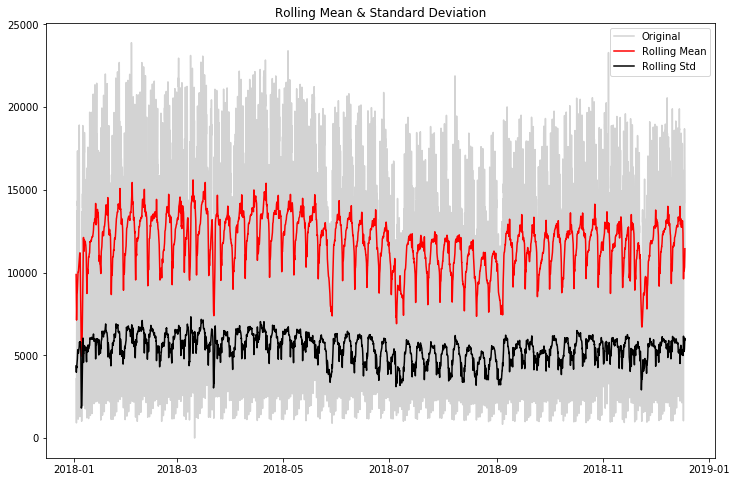

Results of Dickey-Fuller Test:
Test Statistic                -1.024357e+01
p-value                        4.680581e-18
#Lags Used                     3.500000e+01
Number of Observations Used    8.388000e+03
Critical Value (1%)           -3.431130e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566953e+00
dtype: float64


In [21]:
test_stationarity(data_hr_2018[:'2018-12-17'].demand.compute(), 24)

First difference

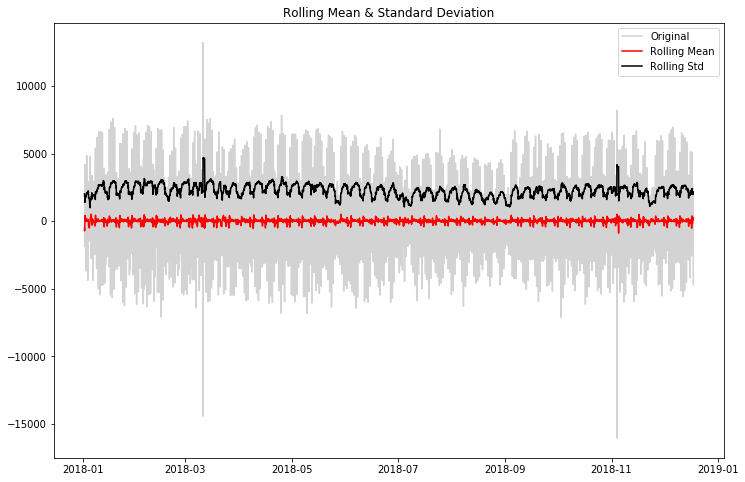

Results of Dickey-Fuller Test:
Test Statistic                  -20.732192
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8385.000000
Critical Value (1%)              -3.431130
Critical Value (5%)              -2.861885
Critical Value (10%)             -2.566954
dtype: float64


In [22]:
test_stationarity((data_hr_2018[:'2018-12-17'].demand.compute() - data_hr_2018[:'2018-12-17'].demand.compute().shift(1)).dropna(), 24)


24h difference

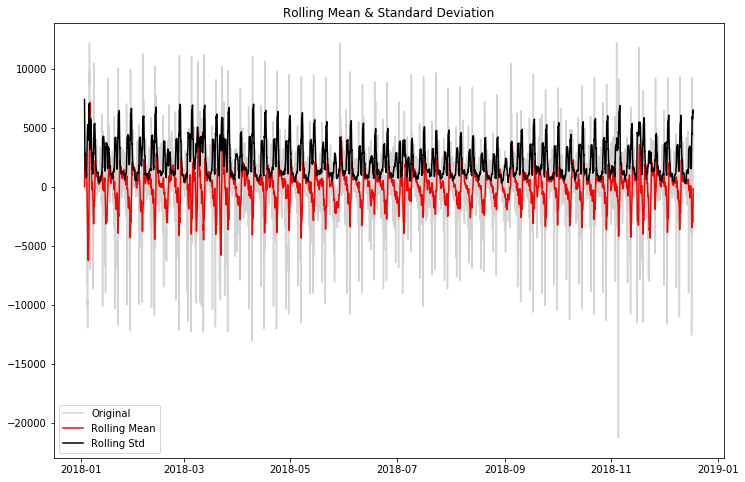

Results of Dickey-Fuller Test:
Test Statistic                -1.354765e+01
p-value                        2.443885e-25
#Lags Used                     3.700000e+01
Number of Observations Used    8.362000e+03
Critical Value (1%)           -3.431132e+00
Critical Value (5%)           -2.861886e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [23]:
test_stationarity((data_hr_2018[:'2018-12-17'].demand.compute() - data_hr_2018[:'2018-12-17'].demand.compute().shift(24)).dropna(), 24)


### Fare amount

Raw data

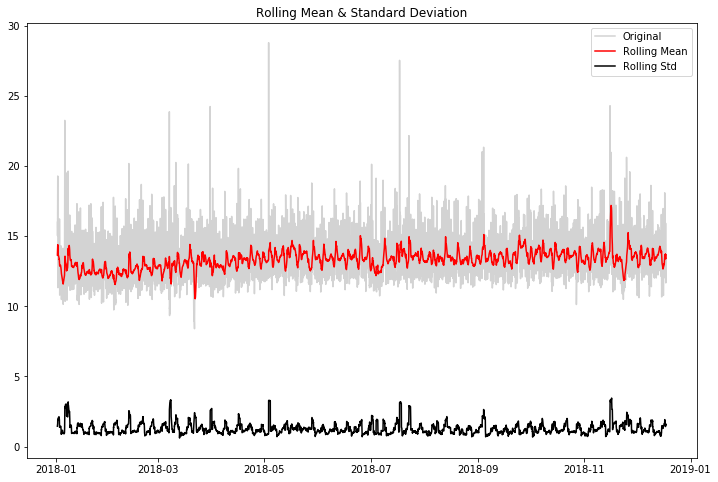

Results of Dickey-Fuller Test:
Test Statistic                -1.194164e+01
p-value                        4.528604e-22
#Lags Used                     3.700000e+01
Number of Observations Used    8.379000e+03
Critical Value (1%)           -3.431131e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [24]:
test_stationarity(data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute(), 24)

First difference

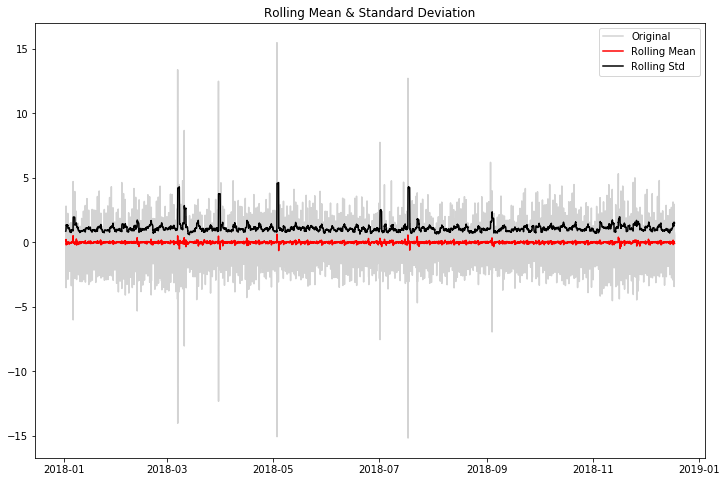

Results of Dickey-Fuller Test:
Test Statistic                  -21.070779
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8378.000000
Critical Value (1%)              -3.431131
Critical Value (5%)              -2.861885
Critical Value (10%)             -2.566954
dtype: float64


In [25]:
test_stationarity((data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute() - data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute().shift(1)).dropna(), 24)


24h difference

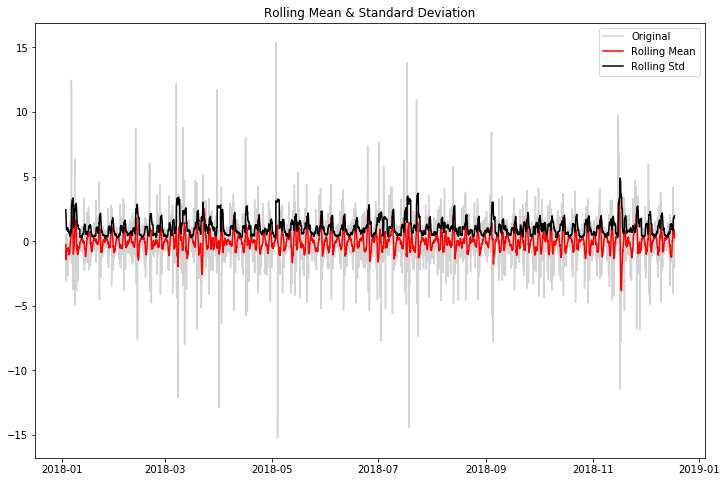

Results of Dickey-Fuller Test:
Test Statistic                  -23.029386
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    8365.000000
Critical Value (1%)              -3.431132
Critical Value (5%)              -2.861886
Critical Value (10%)             -2.566954
dtype: float64


In [26]:
test_stationarity((data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute() - data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute().shift(24)).dropna(), 24)


### Tip_ratio

Raw data

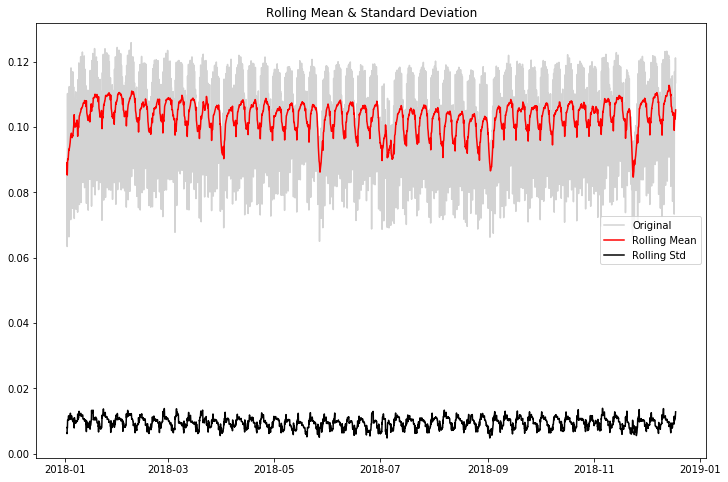

Results of Dickey-Fuller Test:
Test Statistic                -1.052371e+01
p-value                        9.536748e-19
#Lags Used                     3.600000e+01
Number of Observations Used    8.387000e+03
Critical Value (1%)           -3.431130e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566953e+00
dtype: float64


In [27]:
test_stationarity(data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute(), 24)

First difference

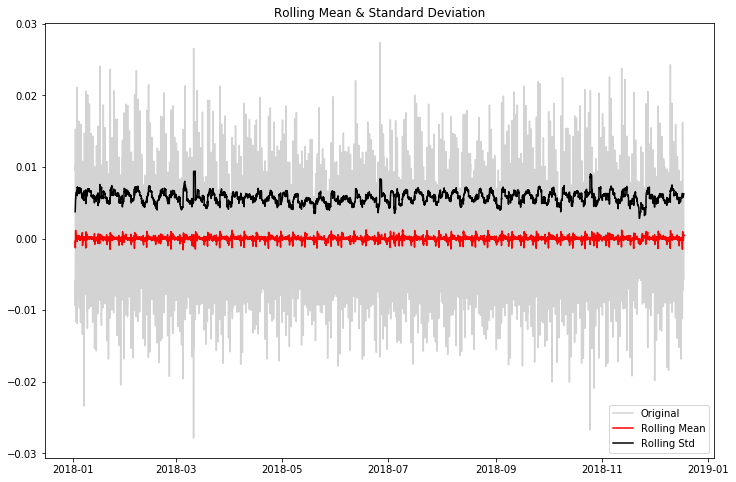

Results of Dickey-Fuller Test:
Test Statistic                -1.408875e+01
p-value                        2.745450e-26
#Lags Used                     3.700000e+01
Number of Observations Used    8.385000e+03
Critical Value (1%)           -3.431130e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [28]:
test_stationarity((data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute() - data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute().shift(1)).dropna(), 24)


24h difference

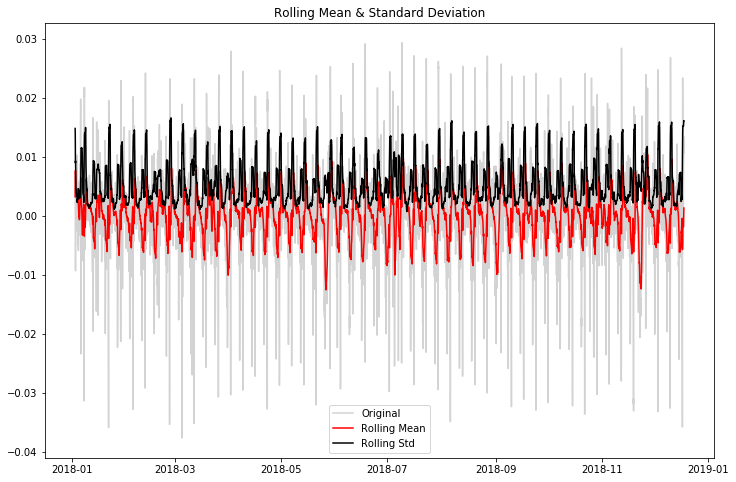

Results of Dickey-Fuller Test:
Test Statistic                -1.279417e+01
p-value                        6.973544e-24
#Lags Used                     3.600000e+01
Number of Observations Used    8.363000e+03
Critical Value (1%)           -3.431132e+00
Critical Value (5%)           -2.861886e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [29]:
test_stationarity((data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute() - data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute().shift(24)).dropna(), 24)


### Trip distance

Raw data

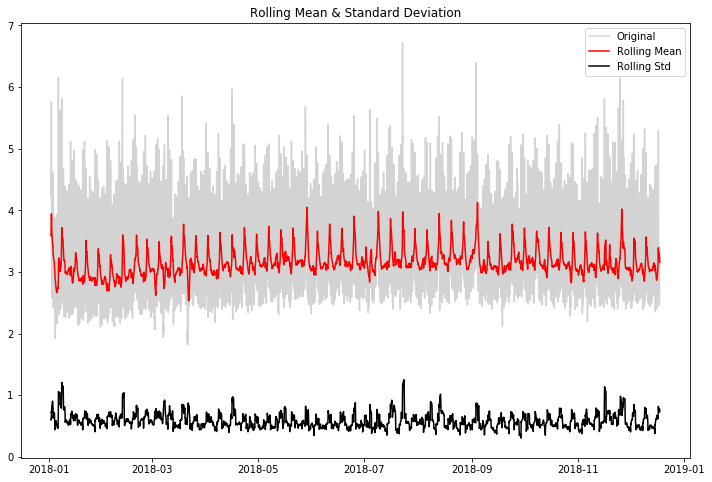

Results of Dickey-Fuller Test:
Test Statistic                -1.452635e+01
p-value                        5.420512e-27
#Lags Used                     3.700000e+01
Number of Observations Used    8.385000e+03
Critical Value (1%)           -3.431130e+00
Critical Value (5%)           -2.861885e+00
Critical Value (10%)          -2.566954e+00
dtype: float64


In [30]:
test_stationarity(data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute(), 24)

First difference

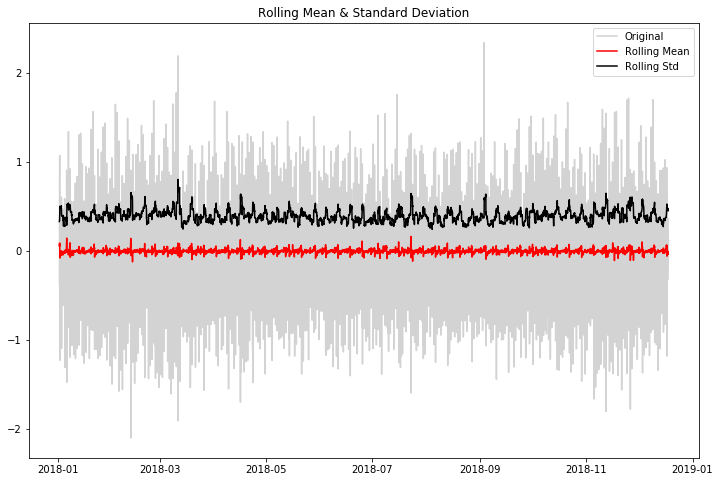

Results of Dickey-Fuller Test:
Test Statistic                  -19.448868
p-value                           0.000000
#Lags Used                       37.000000
Number of Observations Used    8384.000000
Critical Value (1%)              -3.431130
Critical Value (5%)              -2.861885
Critical Value (10%)             -2.566954
dtype: float64


In [31]:
test_stationarity((data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute() - data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute().shift(1)).dropna(), 24)

24h difference

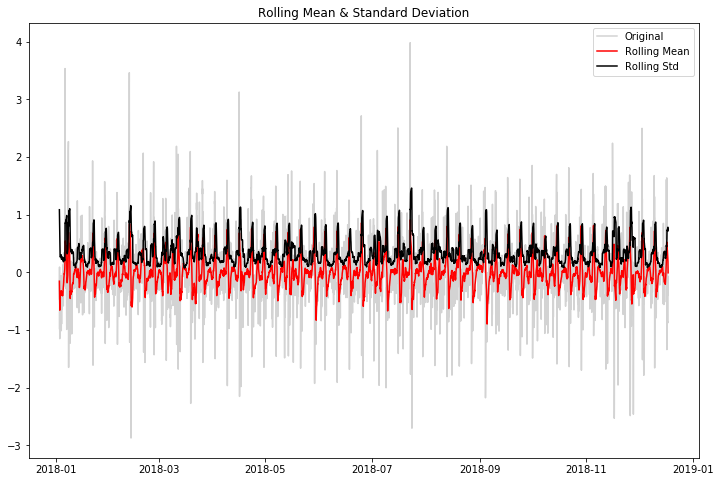

Results of Dickey-Fuller Test:
Test Statistic                  -21.645546
p-value                           0.000000
#Lags Used                       27.000000
Number of Observations Used    8371.000000
Critical Value (1%)              -3.431131
Critical Value (5%)              -2.861885
Critical Value (10%)             -2.566954
dtype: float64


In [32]:
test_stationarity((data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute() - data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute().shift(24)).dropna(), 24)

## Autocorrelation plots

### Demand

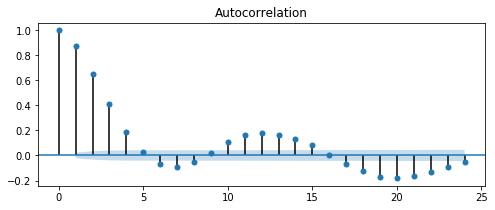

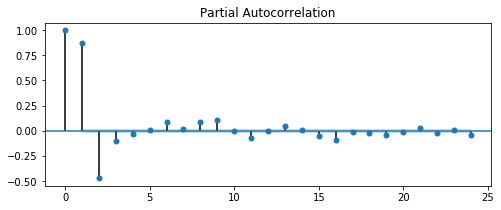

In [33]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf((data_hr_2018[:'2018-12-17'].demand.compute() - data_hr_2018[:'2018-12-17'].demand.compute().shift(24)).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf((data_hr_2018[:'2018-12-17'].demand.compute() - data_hr_2018[:'2018-12-17'].demand.compute().shift(24)).dropna(),ax=ax, lags=24);

### Fare

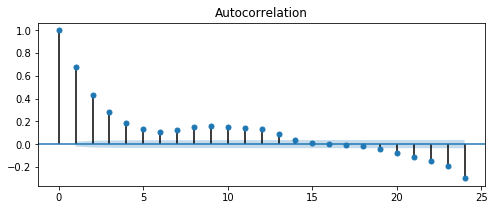

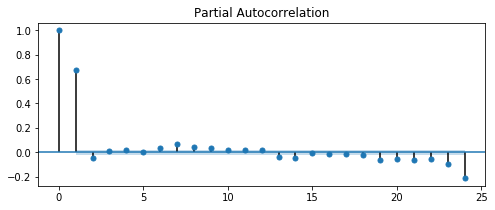

In [34]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf((data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute() - data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute().shift(24)).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf((data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute() - data_hr_2018[:'2018-12-17'].fare_amount_avg[data_hr_2018['fare_amount_avg'] < 30].compute().shift(24)).dropna(),ax=ax, lags=24);

### Tip ratio

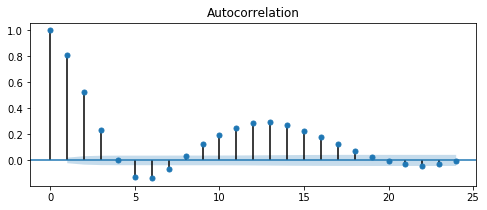

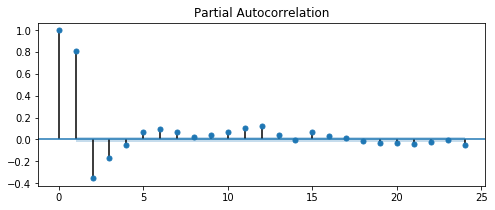

In [35]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf((data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute() - data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute().shift(24)).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf((data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute() - data_hr_2018[:'2018-12-17'].tip_ratio_avg.compute().shift(24)).dropna(),ax=ax, lags=24);

### Trip distance

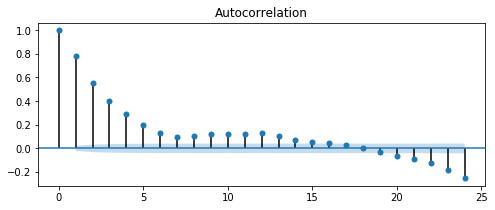

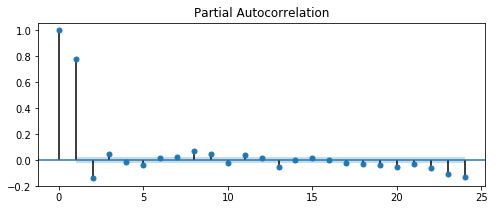

In [36]:
fig, ax = plt.subplots(figsize=(8,3))
plot_acf((data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute() - data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute().shift(24)).dropna(),ax=ax, lags=24);

fig, ax = plt.subplots(figsize=(8,3))
plot_pacf((data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute() - data_hr_2018[:'2018-12-17'].trip_distance_avg[data_hr_2018['trip_distance_avg'] < 10].compute().shift(24)).dropna(),ax=ax, lags=24);

## Demand Forecasting

In [19]:
demand = data_hr_2018.demand.compute()

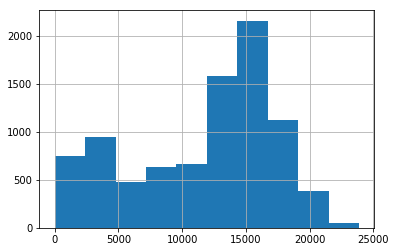

In [20]:
demand.hist()

<Figure size 432x288 with 0 Axes>

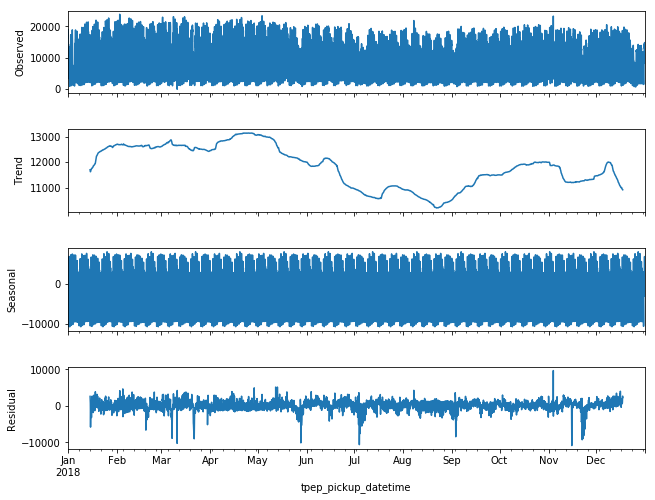

In [21]:
decomposition = seasonal_decompose(demand, freq = 672)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(10, 8)

#### First approach ARIMA (Auro Regressive Integrated Moving Average) - use of auto arima to find best order for the model

Based on autocorrelation plots 3, 1, 3 order seems to be working best

In [29]:
%time first_fit = auto_arima(demand)

/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 5min 39s, sys: 3min 38s, total: 9min 18s
Wall time: 3min 38s


In [31]:
first_fit

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args=None,
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

Automated search found that 3, 1, 3 order should be working best

In [30]:
first_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -76557.573
Date:                Mon, 25 Nov 2019   AIC                         153131.146
Time:                        14:35:02   BIC                         153187.769
Sample:                             0   HQIC                        153150.440
                               - 8760                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.1813      0.343      3.441      0.001       0.509       1.854
ar.L1          2.0638      0.021     97.440      0.000       2.022       2.105
ar.L2         -1.3281      0.040    -32.967      0.000      -1.407      -1.249
ar.L3          0.2079      0.022      9.659      0.000       0.166       0.250
ma.L1         -1.4883      0.018    -80.753      0.000      -1.524      -1.452
ma.L2          0.1045      0.031      3.341      0.001       0.043       0.166
ma.L3          0.4017      0.014     28.367      0.000       0.374       0.429
sigma2      2.596e+06   8.62e-07   3.01e+12      0.000     2.6e+06     2.6e+06
===================================================================================
Ljung-Box (Q):                     5198.81   Jarque-Bera (JB):             52237.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.94
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.38e+26. Standard errors may be unstable.
"""

Verification of same order with statsmodels

In [33]:
model = sm.tsa.statespace.SARIMAX(demand,
                                  order=(3,1,3), 
                                  seasonal_order=(0,0,0,1), 
                                  scoring='mse', 
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [34]:
%time results = model.fit()
print(results.summary().tables[1])

CPU times: user 8.78 s, sys: 164 ms, total: 8.95 s
Wall time: 8.72 s
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0745      0.022     94.526      0.000       2.031       2.118
ar.L2         -1.3498      0.042    -32.373      0.000      -1.432      -1.268
ar.L3          0.2197      0.022      9.849      0.000       0.176       0.263
ma.L1         -1.4943      0.019    -78.496      0.000      -1.532      -1.457
ma.L2          0.1143      0.032      3.538      0.000       0.051       0.178
ma.L3          0.3976      0.015     27.232      0.000       0.369       0.426
sigma2      2.681e+06   4.45e-08   6.02e+13      0.000    2.68e+06    2.68e+06


In [35]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                 demand   No. Observations:                 8760
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -76533.551
Date:                Mon, 25 Nov 2019   AIC                         153081.102
Time:                        14:41:02   BIC                         153130.644
Sample:                    01-01-2018   HQIC                        153097.983
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0745      0.022     94.526      0.000       2.031       2.118
ar.L2         -1.3498      0.042    -32.373      0.000      -1.432      -1.268
ar.L3          0.2197      0.022      9.849      0.000       0.176       0.263
ma.L1         -1.4943      0.019    -78.496      0.000      -1.532      -1.457
ma.L2          0.1143      0.032      3.538      0.000       0.051       0.178
ma.L3          0.3976      0.015     27.232      0.000       0.369       0.426
sigma2      2.681e+06   4.45e-08   6.02e+13      0.000    2.68e+06    2.68e+06
===================================================================================
Ljung-Box (Q):                     5115.86   Jarque-Bera (JB):             53502.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.18e+29. Standard errors may be unstable.
"""

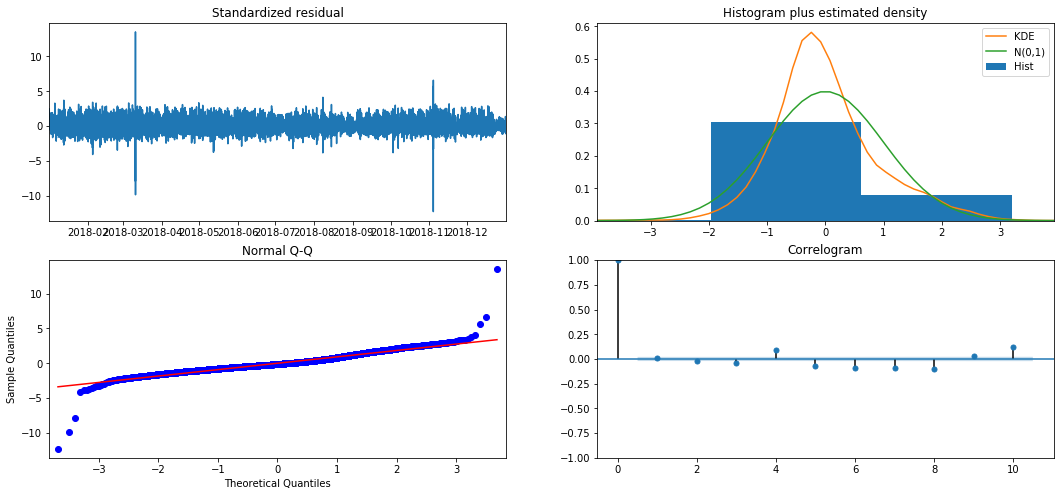

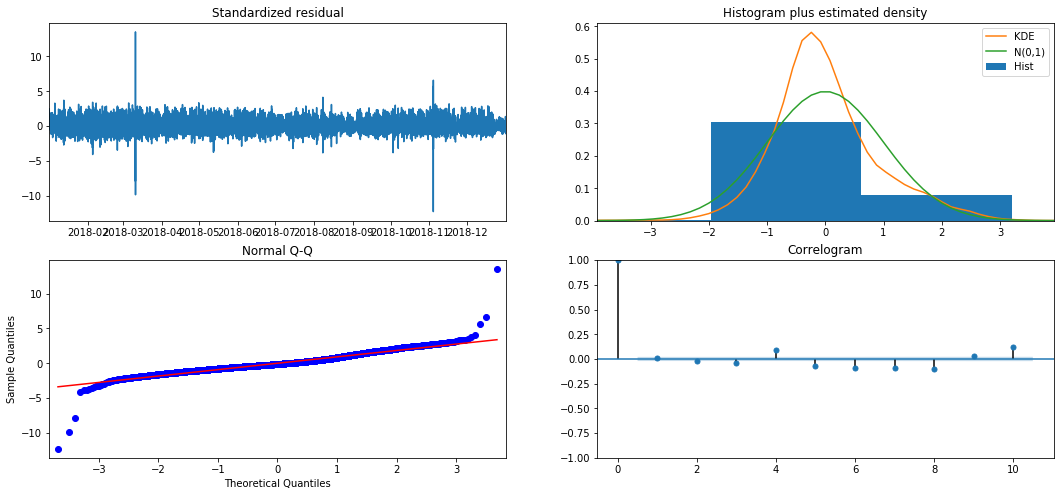

In [36]:
results.plot_diagnostics(figsize=(18, 8))

Prediction with knowledge of previous point data - Dynamic = False

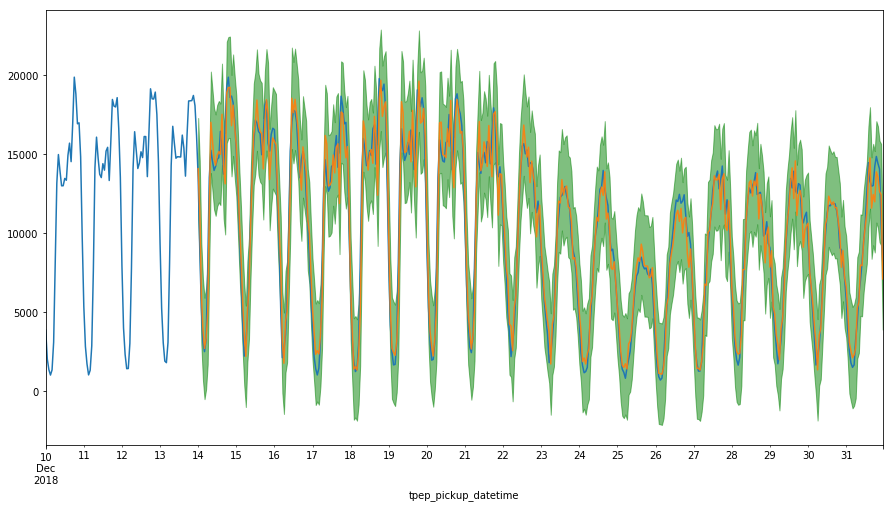

In [48]:
plt.figure(figsize = (15,8))
ax = demand['2018-12-10':].plot(label='observed')
pred = results.get_prediction(start = pd.to_datetime('2018-12-14'), dynamic = False)
pred_conf = pred.conf_int()
pred.predicted_mean['2018-12-10':].plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

Prediction without knowledge of previous point data - Dynamic = True

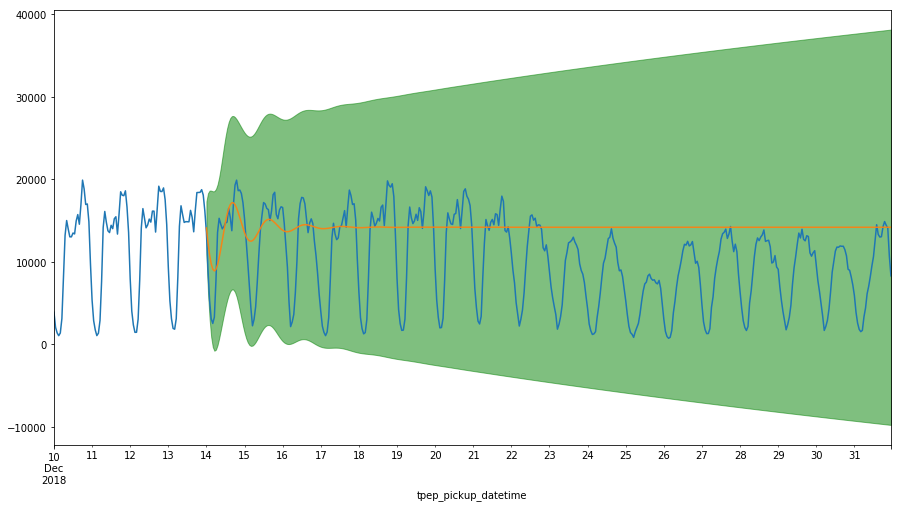

In [49]:
plt.figure(figsize = (15,8))
ax = demand['2018-12-10':].plot(label='observed')
pred = results.get_prediction(start = pd.to_datetime('2018-12-14'), dynamic = True)
pred_conf = pred.conf_int()
pred.predicted_mean['2018-12-10':].plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#### Second approach SARIMA (Seasonal Auro Regressive Integrated Moving Average) - use of auto arima to find best order for the model

In [ ]:
%time second_fit = auto_arima(demand, seasonal=True, m=7) # adding weekly seasonality

CPU times: user 34min 49s, sys: 16min 29s, total: 51min 18s
Wall time: 24min 47s

In [53]:
second_fit

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args=None,
   seasonal_order=(2, 0, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=False, transparams=True, trend=None,
   with_intercept=True)

In [54]:
second_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 8760
Model:             SARIMAX(3, 1, 3)x(2, 0, 2, 7)   Log Likelihood              -76314.560
Date:                           Mon, 25 Nov 2019   AIC                         152653.120
Time:                                   15:17:43   BIC                         152738.054
Sample:                                        0   HQIC                        152682.060
                                          - 8760                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0298      0.581      0.051      0.959      -1.109       1.168
ar.L1          2.1001      0.033     63.520      0.000       2.035       2.165
ar.L2         -1.3984      0.061    -22.755      0.000      -1.519      -1.278
ar.L3          0.2435      0.032      7.614      0.000       0.181       0.306
ma.L1         -1.5443      0.030    -50.940      0.000      -1.604      -1.485
ma.L2          0.2483      0.048      5.186      0.000       0.154       0.342
ma.L3          0.3035      0.019     15.890      0.000       0.266       0.341
ar.S.L7       -1.8779      0.007   -274.972      0.000      -1.891      -1.865
ar.S.L14      -0.9408      0.006   -149.321      0.000      -0.953      -0.928
ma.S.L7        1.8771      0.011    174.558      0.000       1.856       1.898
ma.S.L14       0.9156      0.010     88.438      0.000       0.895       0.936
sigma2      2.679e+06   2.14e-06   1.25e+12      0.000    2.68e+06    2.68e+06
===================================================================================
Ljung-Box (Q):                     3950.55   Jarque-Bera (JB):             52879.85
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.73   Skew:                             0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+26. Standard errors may be unstable.
"""

Verification of same order with statsmodels

In [55]:
model_2 = sm.tsa.statespace.SARIMAX(demand,
                                  order=(3,1,3), 
                                  seasonal_order=(2,0,2,7), 
                                  scoring='mse', 
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


In [56]:
%time results_2 = model_2.fit()
print(results_2.summary().tables[1])

/opt/conda/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 1min 34s, sys: 284 ms, total: 1min 34s
Wall time: 1min 34s
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8222      0.019     97.321      0.000       1.786       1.859
ar.L2         -0.8544      0.035    -24.386      0.000      -0.923      -0.786
ar.L3         -0.0400      0.018     -2.164      0.030      -0.076      -0.004
ma.L1         -1.3104      0.016    -81.163      0.000      -1.342      -1.279
ma.L2         -0.2146      0.026     -8.106      0.000      -0.266      -0.163
ma.L3          0.5506      0.012     44.938      0.000       0.527       0.575
ar.S.L7       -0.5957      0.420     -1.417      0.156      -1.419       0.228
ar.S.L14       0.0205      0.172      0.119      0.905      -0.316       0.357
ma.S.L7        0.4062      0.417      0.973      0.330      -0.412       1.224
ma.S.L14      -0.0823      0.105     -0.783      0.434  

In [57]:
results_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                            demand   No. Observations:                 8760
Model:             SARIMAX(3, 1, 3)x(2, 0, 2, 7)   Log Likelihood              -76419.321
Date:                           Mon, 25 Nov 2019   AIC                         152860.643
Time:                                   15:20:03   BIC                         152938.476
Sample:                               01-01-2018   HQIC                        152887.166
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8222      0.019     97.321      0.000       1.786       1.859
ar.L2         -0.8544      0.035    -24.386      0.000      -0.923      -0.786
ar.L3         -0.0400      0.018     -2.164      0.030      -0.076      -0.004
ma.L1         -1.3104      0.016    -81.163      0.000      -1.342      -1.279
ma.L2         -0.2146      0.026     -8.106      0.000      -0.266      -0.163
ma.L3          0.5506      0.012     44.938      0.000       0.527       0.575
ar.S.L7       -0.5957      0.420     -1.417      0.156      -1.419       0.228
ar.S.L14       0.0205      0.172      0.119      0.905      -0.316       0.357
ma.S.L7        0.4062      0.417      0.973      0.330      -0.412       1.224
ma.S.L14      -0.0823      0.105     -0.783      0.434      -0.288       0.124
sigma2      2.681e+06   9.35e-07   2.87e+12      0.000    2.68e+06    2.68e+06
===================================================================================
Ljung-Box (Q):                     5040.76   Jarque-Bera (JB):             36622.86
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.72   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.02
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.47e+27. Standard errors may be unstable.
"""

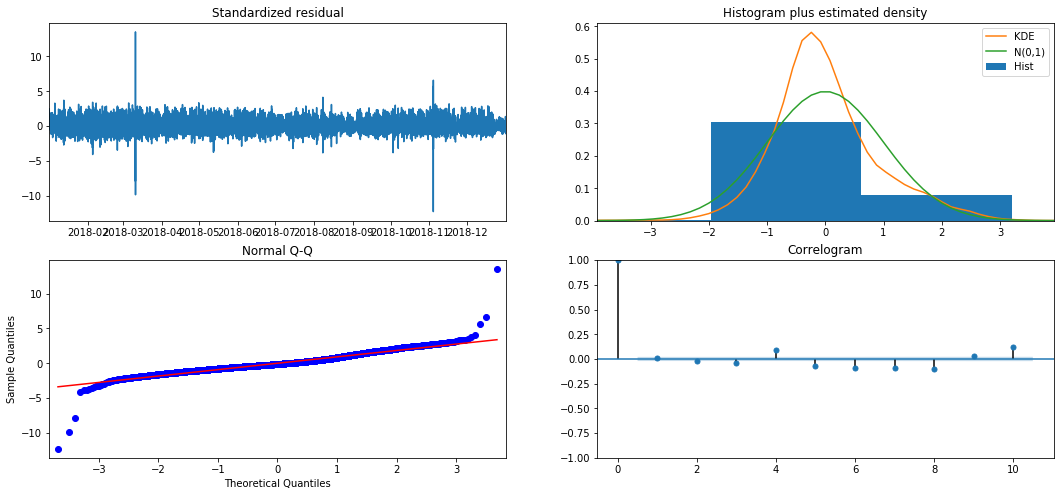

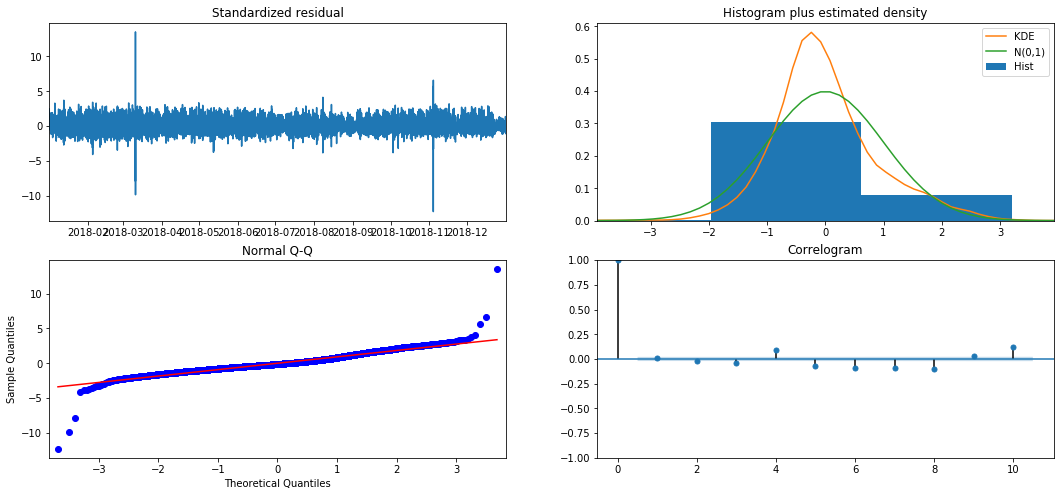

In [58]:
results.plot_diagnostics(figsize=(18, 8))

Prediction with knowledge of previous point data - Dynamic = False

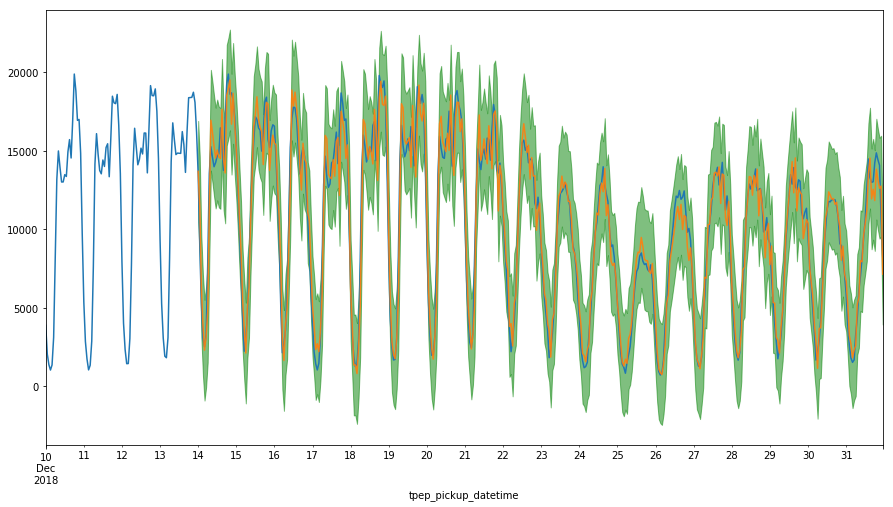

In [59]:
Prediction with knowledge of previous point data - Dynamic = Falseplt.figure(figsize = (15,8))
ax = demand['2018-12-10':].plot(label='observed')
pred = results_2.get_prediction(start = pd.to_datetime('2018-12-14'), dynamic = False)
pred_conf = pred.conf_int()
pred.predicted_mean['2018-12-10':].plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

Prediction without knowledge of previous point data - Dynamic = True

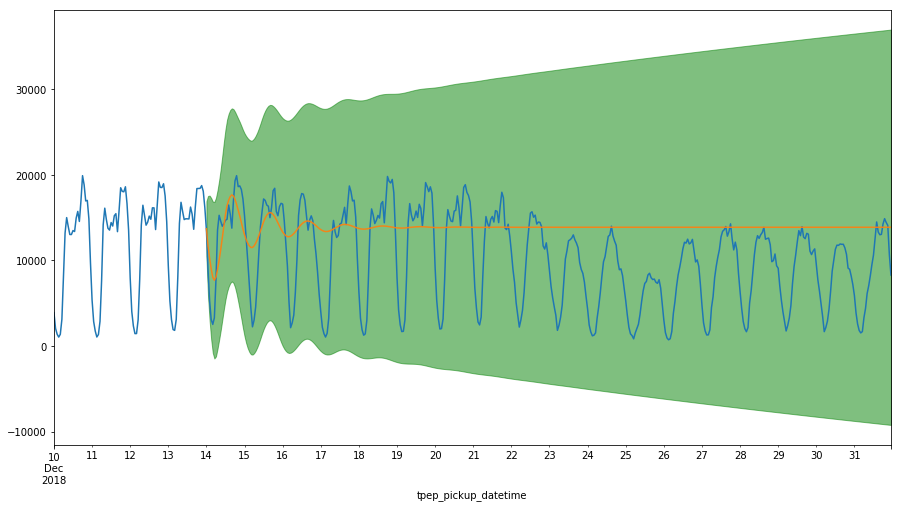

In [60]:
plt.figure(figsize = (15,8))
ax = demand['2018-12-10':].plot(label='observed')
pred = results_2.get_prediction(start = pd.to_datetime('2018-12-14'), dynamic = True)
pred_conf = pred.conf_int()
pred.predicted_mean['2018-12-10':].plot(ax=ax, label='One-step ahead Forecast', alpha=.9)
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='g', alpha=.5)

#### Third approach auto arima with stepwise fit to find best order for the model

In [ ]:
%time stepwise_fit = auto_arima(demand, start_p=0, start_q=0, max_p=6, max_q=3, seasonal=True, m=7,d=None, 
                                trace=True,error_action='ignore',   suppress_warnings=True,  stepwise=True)

Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 0, 1, 7); AIC=158637.355, BIC=158665.667, Fit time=4.801 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=160036.889, BIC=160051.044, Fit time=0.301 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=155399.076, BIC=155427.387, Fit time=4.810 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=155159.515, BIC=155187.826, Fit time=12.486 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=155195.543, BIC=155230.932, Fit time=9.840 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=155747.785, BIC=155769.018, Fit time=1.549 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 2, 7); AIC=155194.720, BIC=155230.110, Fit time=10.914 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=155085.568, BIC=155128.035, Fit time=61.443 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=154751.111, BIC=154800.656, Fit time=41.159 secon

In [75]:
stepwise_fit

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 3),
   out_of_sample_size=0, scoring='mse', scoring_args=None,
   seasonal_order=(2, 0, 2, 7), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend=None,
   with_intercept=True)

Stepwise fit found same order as previous search